# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from workspace_utils import keep_awake
import jdc
%matplotlib inline

In [3]:

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### Install pytorch

In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

### Define the mlp network.
We will use this for both the actor and critic networks.

In [5]:
class FeedForwardNN(nn.Module):
    """
    A standard in_dim-64-64-out_dim Feed Forward Neural Network.
    """
    def __init__(self, in_dim, hidden_dim, out_dim, seed=42):
        """
        Initialize the network and set up the layers.

            Parameters:
                in_dim - input dimensions as an int
                out_dim - output dimensions as an int

            Return:
                None
        """
        super(FeedForwardNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(in_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, out_dim)

    def forward(self, obs):
        """
            Runs a forward pass on the neural network.

            Parameters:
                obs - observation to pass as input

            Return:
                output - the output of our forward pass
        """
        # Convert observation to tensor if it's a numpy array
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        x = F.relu(self.layer1(obs))
        x = F.relu(self.layer2(x))
        output = self.layer3(x)
        return output

### Check which device we are using.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using: ", device)

Using:  cuda:0


### Implement our PPO agent class.
Here we setup the environment, our actor and critic models plus other required variables.
We are using the jdc module to make it easer to work with classes in jupyter notebooks

In [7]:
class PPO:
    def __init__(self, env, hidden_dim, 
                 lr = 1e-3, 
                 clip_epsilon=0.1, 
                 discount=0.95, 
                 n_updates = 5
                 ):

        self.hidden_dim = hidden_dim
        self.n_updates = n_updates
        self.lr = lr
        self.discount = discount
        self.clip_epsilon = clip_epsilon
        # Environment variables
        self.env = env
        self.brain_name = env.brain_names[0]
        self.brain = env.brains[self.brain_name]
        self.action_size = self.brain.vector_action_space_size
        self.state_size = self.brain.vector_observation_space_size

        self.actor = FeedForwardNN(self.state_size, self.hidden_dim, self.action_size).to(device)                                                   # ALG STEP 1
        self.critic = FeedForwardNN(self.state_size, self.hidden_dim, 1).to(device)

        # Initialize optimizers for actor and critic
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=self.lr)

        # Initialize the covariance matrix used to query the actor for actions
        self.cov_var = torch.full(size=(self.action_size,), fill_value=0.5)
        self.cov_mat = torch.diag(self.cov_var)

### get_actions
This method takes a batch of states from the environment and returns an action and the log_probs of the action.
We do this using torch.MultivariateNormal to sample an action rather than taking the action directly from the output of the actor.

In [8]:
%%add_to PPO

def get_actions(self, states):
    """
        Queries an action from the actor network, should be called from rollout.

        Parameters:
            obs - the observation at the current timestep

        Return:
            action - the action to take, as a numpy array
            log_prob - the log probability of the selected action in the distribution
    """
    # Query the actor network for a mean action
    mean = self.actor(states).to(torch.device('cpu'))

    dist = MultivariateNormal(mean, self.cov_mat)

    # Sample an action from the distribution
    action = dist.sample()


    # Calculate the log probability for that action
    log_prob = dist.log_prob(action)

    return action, log_prob.detach()

### compute_actor_log_probs
Given a batch of states and actions it returns the log_probs of the input actions given the current current action model weights.

In [9]:
%%add_to PPO

def compute_actor_log_probs(self, batch_obs, batch_acts):
    """
        Estimate the log probs of
        each action in the most recent batch with the most recent
        iteration of the actor network. Should be called from learn.

        Parameters:
            batch_obs - the observations from the most recently collected batch as a tensor.
                        Shape: (number of timesteps in batch, dimension of observation)
            batch_acts - the actions from the most recently collected batch as a tensor.
                        Shape: (number of timesteps in batch, dimension of action)

        Return:
            log_probs - the log probabilities of the actions taken in batch_acts given batch_obs
    """
    # Calculate the log probabilities of batch actions using most recent actor network.
    # This segment of code is similar to that in get_action()
    mean = self.actor(batch_obs).to(torch.device('cpu'))
    dist = MultivariateNormal(mean, self.cov_mat)
    log_probs = dist.log_prob(batch_acts)

    # Return the value vector V of each observation in the batch
    # and log probabilities log_probs of each action in the batch
    return log_probs

### Methods to compute the normalized forward returns

In [10]:
%%add_to PPO

def compute_future_rewards(self, rewards):
        discounts = self.discount**np.arange(len(rewards))
        discounted_rewards = np.asarray(rewards) * discounts[:,np.newaxis]
        future_rewards = discounted_rewards[::-1].cumsum(axis=0)[::-1]
        return future_rewards

def compute_normalize_future_rewards(self, rewards):
    future_rewards = self.compute_future_rewards(rewards)
    mean = np.mean(future_rewards, axis=1)
    std = np.std(future_rewards, axis=1) + 1.0e-10
    normalized_rewards = (future_rewards - mean[:, np.newaxis]) / std[:, np.newaxis]
    return torch.tensor(normalized_rewards, dtype=torch.float32).to(device)

### Rolls out full epsiodes for all the agents.
In this case 20 agents.

In [11]:
%%add_to PPO

def rollout(self, steps):
    env_info = self.env.reset(train_mode=True)[self.brain_name]
    num_agents = len(env_info.agents)
    state = env_info.vector_observations 
    
    state_list = []
    action_list = []
    reward_list = []
    log_prob_list = []
    done_list = []
    
    for i in range(steps):
        state_tensor = torch.tensor(state, dtype = torch.float32).to(device)
        action_tensor, prob_tensor = self.get_actions(state_tensor) 
        actions = np.clip(action_tensor.detach().numpy(), -1, 1)
        
        env_info = self.env.step(actions)[self.brain_name] 
        next_state = env_info.vector_observations         # get next state (for each agent)
        reward = env_info.rewards                         # get reward (for each agent)
        done = env_info.local_done
        
        state_list.append(state_tensor)
        action_list.append(action_tensor)
        log_prob_list.append(prob_tensor)
        reward_list.append(reward)
        done_list.append(done)
        
        state = next_state
        
        if np.any(done):
            break
        
    states_tensor = torch.stack(state_list).to(device)
    actions_tensor = torch.stack(action_list)
    log_probs_tensor = torch.stack(log_prob_list)
    rewards_tensor = torch.tensor(reward_list, dtype=torch.float32)
    dones_tensor = torch.tensor(done_list, dtype=torch.float32)
    
    return (states_tensor, actions_tensor, log_probs_tensor, rewards_tensor, dones_tensor)  

### Method to compute the advantage

In [12]:
%%add_to PPO

def compute_advantage(self, states, forward_normalised_returns):
    """
        Estimate the values of each observation of
        each action in the most recent batch with the most recent
        iteration of the actor network. Should be called from learn.
    """
    V = self.critic(states).squeeze()
    adv = forward_normalised_returns - V.detach()                                                                      # ALG STEP 5
    adv = (adv - adv.mean()) / (adv.std() + 1e-10)
    return adv.to(device)

### This method runs the learning algorithm

In [13]:
%%add_to PPO
def learn(self, num_episodes, num_agents=20, print_every=10, max_episode_steps=1000):
    # Create a batch of environments
    losses = []
    rewards = []
    scores = np.zeros(num_agents)
    for episode in keep_awake(range(1, num_episodes + 1)):
        # Step all the environments
        states_tensor, actions_tensor, log_probs_tensor, rewards_tensor, dones_tensor = self.rollout(max_episode_steps)
    
        rewards_normalize_future = self.compute_normalize_future_rewards(rewards_tensor)
        
        # Calculate advantage at k-th iteration
        A_k = self.compute_advantage(states_tensor, rewards_normalize_future)
        
        for _ in range(self.n_updates): 

            V = self.critic(states_tensor).squeeze()
          
            curr_log_probs = self.compute_actor_log_probs(states_tensor, actions_tensor)
            
            ratios = torch.exp(curr_log_probs - log_probs_tensor).to(device)
            
            surr1 = ratios * A_k

            surr2 = torch.clamp(ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * A_k
            
            actor_loss = (-torch.min(surr1, surr2)).mean()
            
            # Calculate actor and critic losses.
            critic_loss = nn.MSELoss()(V, rewards_normalize_future)

            # Calculate gradients and perform backward propagation for actor network
            self.actor_optim.zero_grad()
            actor_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1)
            self.actor_optim.step()

            # Calculate gradients and perform backward propagation for critic network
            self.critic_optim.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
            self.critic_optim.step()
    
        cum_rewards = rewards_tensor.numpy().sum(axis=0)
        rewards.append(np.mean(cum_rewards))
        scores += cum_rewards
           
        if episode % print_every == 0:
            print('Ep {}: Total score (averaged over agents) this episode: {}'.format(episode, np.mean(scores) / print_every))
            scores = np.zeros(num_agents)
            torch.save(self.actor.state_dict(), './ppo_actor.pth')
            torch.save(self.critic.state_dict(), './ppo_critic.pth')
    return rewards

### Initiate our agent

In [14]:
hidden_size = 128
num_updates = 5
learning_rate = 5e-3

ppo_agent = PPO(env, hidden_size,
                lr = learning_rate,
                n_updates=num_updates)

### Run the agent

In [15]:
num_episodes = 600
max_steps = 1000
scores = ppo_agent.learn(num_episodes, max_episode_steps=max_steps)

Ep 10: Total score (averaged over agents) this episode: 0.7725499014183879
Ep 20: Total score (averaged over agents) this episode: 1.1824997296743096
Ep 30: Total score (averaged over agents) this episode: 1.7212494010478259
Ep 40: Total score (averaged over agents) this episode: 2.187749004624784
Ep 50: Total score (averaged over agents) this episode: 2.751298558115959
Ep 60: Total score (averaged over agents) this episode: 3.6034979252517223
Ep 70: Total score (averaged over agents) this episode: 4.11189755871892
Ep 80: Total score (averaged over agents) this episode: 4.7701971811428665
Ep 90: Total score (averaged over agents) this episode: 5.537746739014983
Ep 100: Total score (averaged over agents) this episode: 6.150946439281106
Ep 110: Total score (averaged over agents) this episode: 7.311345716714859
Ep 120: Total score (averaged over agents) this episode: 8.162445883750916
Ep 130: Total score (averaged over agents) this episode: 9.319145819991828
Ep 140: Total score (averaged 

### Display a learning graph

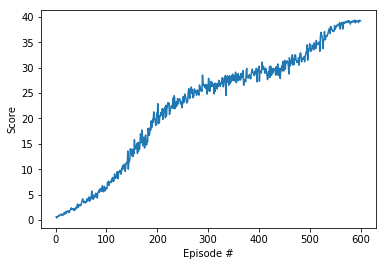

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()